In [ ]:
# divergence preprocessing

#### Load Modules ####
import pandas as pd
import numpy as np
import json
import mne
import matplotlib.pyplot as plt

#### Load and Manipulate Data ####
data = pd.read_csv('s3eeg.csv') #load in eeg file
markers = pd.read_csv('s3marker.csv') #load in markers file

data_eeg = list(map(json.loads, data['sample'].to_list()))
data_ts = data['timestamp'].to_list()
marker_ts = markers['timestamp'].to_list()

#### Create MNE object ####
ch_names = ['CP3', 'F6', 'C4', 'PO4', 'PO3', 'F5', 'C3', 'CP4']
ch_types = ['eeg'] * 8
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=256)
info.set_montage('standard_1020')

np_data_eeg = np.array(data_eeg).T
raw = mne.io.RawArray(np_data_eeg, info, copy='data')

#### Filter Data ####
raw.filter(0.1, 30, method ='iir') # Throws error but still works
raw.notch_filter(60) # Throws error but still works

#### Manipulate Markers ####
events = markers.to_numpy()
events.shape

marker_match = []
for label in marker_ts:  
    marker_match.append([np.argmin(np.abs(label-data['timestamp'])), 0, 1]) #300/4 -> there are 75 samples that are within a 300 milisecond time segment
events = np.array(marker_match)


#### Epoch Data ####
event_dict = {'stim': 1}
epochs_tmin, epochs_tmax = -0.2, 1.5  # epochs range: [-0.1, 0.4] s
epochs = mne.Epochs(raw=raw, tmin=epochs_tmin, tmax=epochs_tmax,
                    events=events, event_id=event_dict, preload=True)
                    # reject=reject)

#### Average epochs ####
evoked_erp = epochs.average()

#### Plot data ####
p = evoked_erp.plot(spatial_colors=True, gfp=True)


# preprocessing outline 
1. Bandpass IIR filter between 0.1 and 80hz for eegmmidb and 0.1-40hz for berlin
2. Notch filter at 60hz -> not necessary for berlin?
3. auto artifact rejection?
4. FFT -> PSD

In [1]:
import pandas as pd
import numpy as np
import json
import mne
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
# loading in Berlin

dat = loadmat('datasets/berlin1000hz-calib/BCICIV_calib_ds1d_1000Hz.mat', struct_as_record=True)

In [3]:
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'nfo', 'mrk', 'cnt'])

In [4]:
sfreq = dat['nfo']['fs'][0][0][0][0]
EEGdata   = dat['cnt'].T
nchannels, nsamples = EEGdata.shape

chan_names = [s[0] for s in dat['nfo']['clab'][0][0][0]]

event_onsets  = dat['mrk'][0][0][0]
event_codes   = dat['mrk'][0][0][1]

labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes # 0 everywhere except at event onsets 

cl_lab = [s[0] for s in dat['nfo']['classes'][0][0][0]]
cl1    = cl_lab[0]
cl2    = cl_lab[1]

# digitized electrode positions 
xpos = dat['nfo']['xpos']
ypos = dat['nfo']['ypos']

nclasses = len(cl_lab)
nevents = len(event_onsets)

# Print some information
print('Shape of EEG:', EEGdata.shape)
print('Sample rate:', sfreq)
print('Number of channels:', nchannels)
print('Channel names:', chan_names)
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)

Shape of EEG: (59, 1904735)
Sample rate: 1000
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'right']
Number of classes: 2


In [48]:
#bprint(event_onsets[event_codes==1])
for i, e in enumerate(event_onsets[event_codes==1]):
    print(i, e)

0 20945
1 28946
2 36946
3 52946
4 60947
5 68947
6 84948
7 92948
8 100948
9 116949
10 170942
11 202943
12 210943
13 218944
14 234944
15 266946
16 304935
17 312935
18 320936
19 336936
20 344937
21 384938
22 400939
23 408939
24 416939
25 446929
26 454929
27 486930
28 526932
29 534932
30 558933
31 612923
32 620923
33 628924
34 636924
35 660925
36 684926
37 692926
38 730916
39 746917
40 754917
41 770918
42 778918
43 802919
44 810919
45 826920
46 842920
47 872909
48 888910
49 912911
50 1004919
51 1028920
52 1036921
53 1068922
54 1076922
55 1084922
56 1114914
57 1138915
58 1154916
59 1178917
60 1186917
61 1194918
62 1202918
63 1210918
64 1226919
65 1256908
66 1272909
67 1296910
68 1312911
69 1352912
70 1360912
71 1398902
72 1414902
73 1446904
74 1454904
75 1470905
76 1486905
77 1540896
78 1548896
79 1556896
80 1564897
81 1580898
82 1604898
83 1628899
84 1644900
85 1652900
86 1682889
87 1698890
88 1706890
89 1730891
90 1738891
91 1754892
92 1762892
93 1794893
94 1824883
95 1832883
96 1840884
9

In [5]:
# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(0.5*sfreq), int(2.5*sfreq))

# Length of the time window
nsamples = len(win)

# Loop over the classes (right, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):
    
    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]
    
    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    
    # Extract each trial
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEGdata[:, win+onset] # win+onset a vector scalar addition that shifts window by onset
        
# the dimensionality of the data (channels x time x trials)
print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

Shape of trials[cl1]: (59, 2000, 100)
Shape of trials[cl2]: (59, 2000, 100)


In [31]:
%qtconsole

In [6]:
left_hand = np.rollaxis(trials[cl1], 2, 0) # (trials, channels, time)
right_hand = np.rollaxis(trials[cl2], 2, 0)

left_hand.shape

(100, 59, 2000)

In [7]:
data = np.concatenate([left_hand, right_hand])
print(data.shape)

# create labels 
Y = np.concatenate([-np.ones(left_hand.shape[0]),
                     np.ones(right_hand.shape[0])])
print(Y.shape)

(200, 59, 2000)
(200,)


# Create MNE Struct

We need the following information to create MNE structure:

- data ([ndarray]): [trials x chans x samples]
- y ([ndarray]): [class label array [1, labels]]
- sfreq ([int]): [sampling frequency]
- event_id ([dict]): [{1 :'pos', -1 : 'neg'} - class labels id]
- chan_names ([list]): [channel names in a list of strings]

In [8]:
n_channels = 59

# Initialize an info structure
info = mne.create_info(
        ch_names = chan_names,
        ch_types = ['eeg']*nchannels,
        sfreq    = sfreq )  

print('Event created :', info)  

Event created : <Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 1000.0 Hz
>


In [9]:
# digitized electrode positions 
xpos = dat['nfo']['xpos'][0][0]  
ypos = dat['nfo']['ypos'][0][0] 

In [10]:
layout_pos = np.concatenate([xpos, ypos], axis = 1)
layout_pos


array([[-0.20109028,  0.68656518],
       [ 0.20109028,  0.68656518],
       [-0.48547489,  0.52547424],
       [-0.32894737,  0.46520183],
       [-0.16535231,  0.43208641],
       [ 0.        ,  0.421549  ],
       [ 0.16535231,  0.43208641],
       [ 0.32894737,  0.46520183],
       [ 0.48547489,  0.52547424],
       [-0.60591541,  0.27165704],
       [-0.39919579,  0.23384348],
       [-0.19765935,  0.21394494],
       [ 0.        ,  0.20773757],
       [ 0.19765935,  0.21394494],
       [ 0.39919579,  0.23384348],
       [ 0.60591541,  0.27165704],
       [-0.74834683,  0.15177169],
       [-0.52472976,  0.12553103],
       [-0.30963911,  0.11086096],
       [-0.10226303,  0.10426648],
       [ 0.10226303,  0.10426648],
       [ 0.30963911,  0.11086096],
       [ 0.52472976,  0.12553103],
       [ 0.74834683,  0.15177169],
       [-0.87719298,  0.        ],
       [-0.64569058,  0.        ],
       [-0.421549  ,  0.        ],
       [-0.20773757,  0.        ],
       [ 0.        ,

In [11]:
layout = mne.channels.generate_2d_layout(
    xy = layout_pos,
    ch_names=chan_names,
    name ='EEG custom layout',
    )

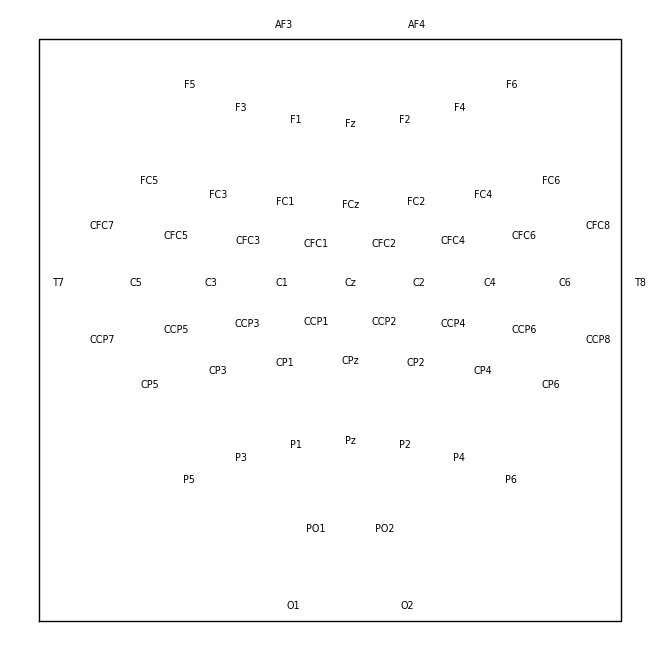

In [12]:
layout.plot();

# MNE Events 
the events array should contain the folowing information:
[samples, onsets, zeros, labels]

In [15]:
event_id = dict(left = -1, right = 1)

In [16]:
# Create an event matrix: events with alternating event codes
eventLength = Y.shape[0]
ev = [i*sfreq*3 for i in range(eventLength)] # 3 seconds between events

events = np.column_stack((np.array(ev,  dtype = int),
                          np.zeros(eventLength,  dtype = int),
                          np.array(Y,  dtype = int)))

In [17]:
events

array([[     0,      0,     -1],
       [  3000,      0,     -1],
       [  6000,      0,     -1],
       [  9000,      0,     -1],
       [ 12000,      0,     -1],
       [ 15000,      0,     -1],
       [ 18000,      0,     -1],
       [ 21000,      0,     -1],
       [ 24000,      0,     -1],
       [ 27000,      0,     -1],
       [ 30000,      0,     -1],
       [ 33000,      0,     -1],
       [ 36000,      0,     -1],
       [ 39000,      0,     -1],
       [ 42000,      0,     -1],
       [ 45000,      0,     -1],
       [ 48000,      0,     -1],
       [ 51000,      0,     -1],
       [ 54000,      0,     -1],
       [ 57000,      0,     -1],
       [ 60000,      0,     -1],
       [ 63000,      0,     -1],
       [ 66000,      0,     -1],
       [ 69000,      0,     -1],
       [ 72000,      0,     -1],
       [ 75000,      0,     -1],
       [ 78000,      0,     -1],
       [ 81000,      0,     -1],
       [ 84000,      0,     -1],
       [ 87000,      0,     -1],
       [ 9

In [18]:
# The time window (in samples) to extract for each trial, here 0.5 -- 2.5 seconds
tmin = 0.5                

# Create the :class:`mne.EpochsArray` object
epochs = mne.EpochsArray(data, info, events, tmin, event_id)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


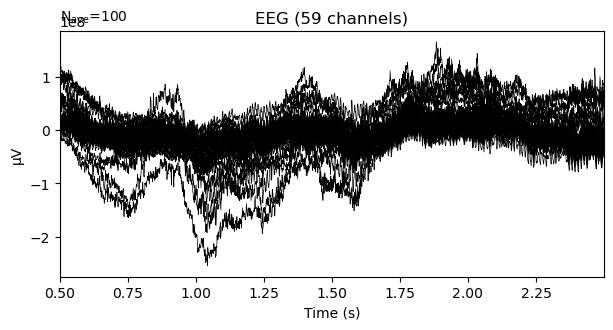

In [19]:
epochs['left'].average().plot();

In [20]:
#epochs.compute_psd(); 
epochs.plot_psd();

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/var/folders/9_/f81q3syj4qd40f4gxdmsrw3c0000gn/T/ipykernel_17992/2703103178.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd();
/Users/anushmutyala/opt/miniconda3/envs/torch/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


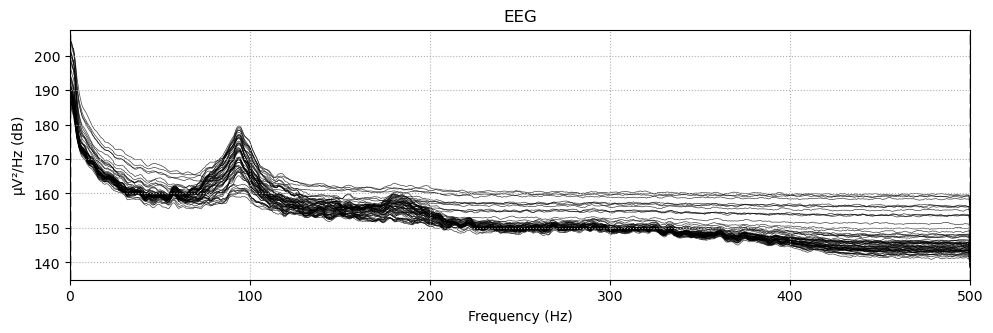

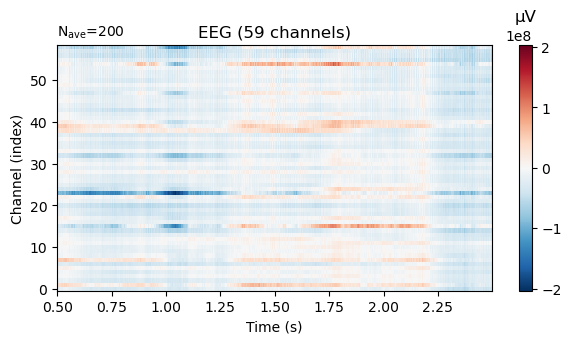

In [21]:
epochs.average().plot_image();

In [22]:
epochs.filter(l_freq=8, h_freq=32)

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 1651 samples (1.651 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 11800 out of 11800 | elapsed:    1.4s finished


Number of events,200
Events,left: 100right: 100
Time range,0.500 – 2.499 sec
Baseline,off


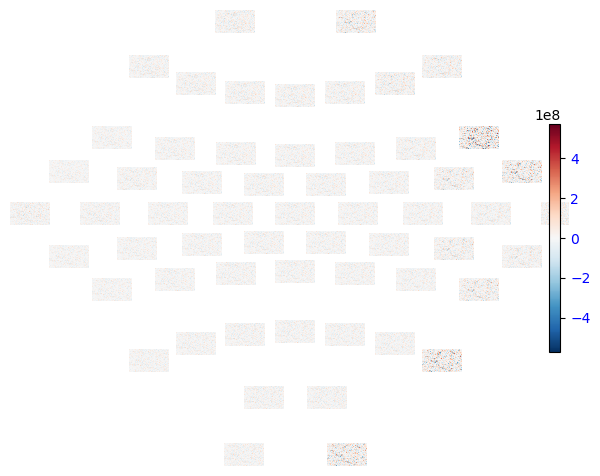

In [70]:
epochs.plot_topo_image(layout=layout, 
                       fig_facecolor='w', font_color='b');

In [33]:
epochs.plot_psd(fmin=8, fmax=32);

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/var/folders/9_/f81q3syj4qd40f4gxdmsrw3c0000gn/T/ipykernel_17992/1408244515.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd(fmin=8, fmax=32);
/Users/anushmutyala/opt/miniconda3/envs/torch/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


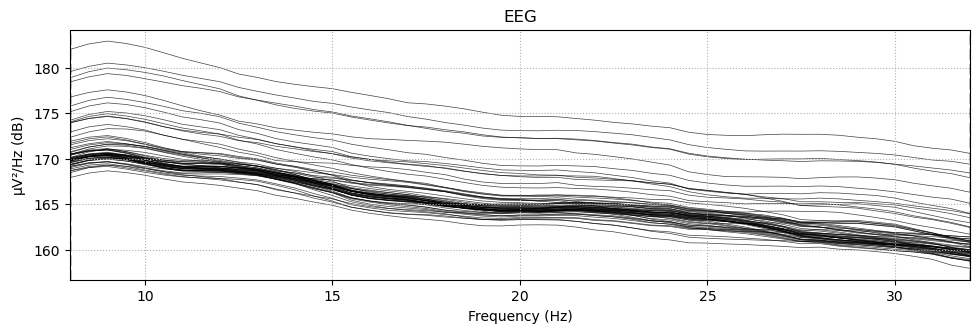

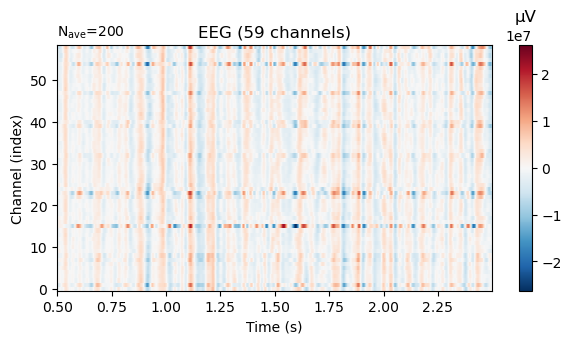

In [34]:
epochs.average().plot_image();

# PSD Algorithm in Scipy

Compute FFT on averaged epoch across channels. To calculate PSD, you take the magnitude squared (powers) of each complex number in the FFT array by multuplying each element with its conjugate, normalized by the number of samples in the epoch (mean square). 

$$ \lambda \cdot \bar{\lambda} = \mid\lambda\mid^2 = a^2+b^2 $$

Where $\lambda$ is the complex number, $\bar{\lambda}$ is the conjugate of $\lambda$, and $a$ and $b$ are the real and imaginary parts of $\lambda$. Mean-square value of any quantity is the power of that quantity. Produces `N/2` frequency bins. 


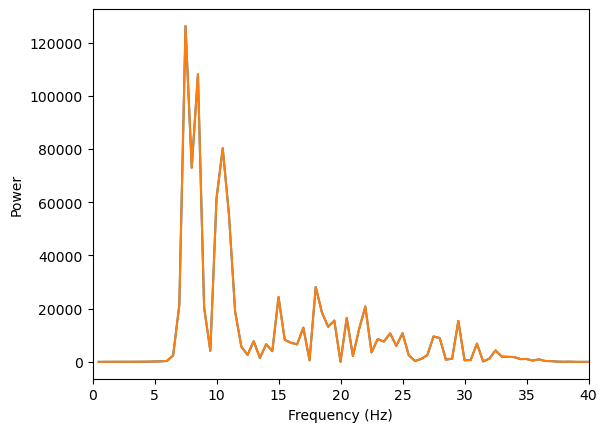

In [62]:
f = epochs.get_data()[0]
# print(sample.shape)
t = epochs.times
dt = t[1] - t[0]
n = len(t)

f_avg = np.mean(f, axis=0) # avg across channel 

fhat = np.fft.fft(f_avg, n) # len of n -> n/2 unique frequency components in complex form
PSD = fhat * np.conj(fhat) / n  # go from amp/hz to watts/Hz or powers

freq = (1/(dt*n))*np.arange(n) # frequency axis -> 1/(dt*n) is the frequency resolution
L = np.arange(1, np.floor(n/2), dtype='int') # only look at the first half of the spectrum

plt.plot(freq[L], PSD[L])
plt.xlim(0, 40)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()








